In [1]:
# 모듈로딩
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn           
import torch.nn.functional as F  
import torch.optim as optim    

In [2]:
# 데이터 준비
fashion_db = 'fashion-mnist'
fashion_data = fetch_openml(name = fashion_db, parser = 'auto')  # as_frame = False로 설정하면 넘파이로 데이터 받는다.

In [3]:
# 데이터 확인
feature = fashion_data['data']
target = fashion_data['target']

In [4]:
# 피처와 타겟 개수 확인
print(f'FEATURE => {feature.shape}, {feature.ndim}D')
print(f'TARGET => {target.shape}, {target.ndim}D')

FEATURE => (70000, 784), 2D
TARGET => (70000,), 1D


In [5]:
# 분류 확인
print(f"FEATURE NAME => {fashion_data['feature_names']}\n")
print(f"TARGET NAME => {fashion_data['target_names']}\n")
print(f"CATEGORIES NAME => {fashion_data['categories']}\n")  # 데이터를 넘파이로 받으면 값 반환
print(f"CATEGORIES => {target.unique()}")

FEATURE NAME => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'p

[2] 데이터 가공 및 전처리 <hr>
- 결측치/중복/이상치 => 없음
- 표준화 => 이미지 동일 크기 및 색상 : 동일 크기와 채널
- 정규화 => 피처 정규화 / 타겟 정규화 

In [6]:
# [2-2] 정규화 ===> 피처 : 784개 색상값 즉, 0 ~ 255 범위 값
norm_feature = feature / 255.

[3] 학습 준비 <hr>
- 데이터 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도학습 - 이진분류 => Linear 클래스 + sigmoid 함수
- 최적화 방법: 경사하강법
- 손실 함수 : 이진 분류 손실 계산 함수 => binary_cross_entropy 

In [7]:
# target 시리즈를 텐서로 변환
target = torch.tensor(target.values.astype('int64'))

In [8]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
target = target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
target

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
# 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000
train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

y_train = target[:limit]
y_test = target[:limit]

# 텐서로 변환
X_train = torch.FloatTensor(train.values) 
X_test = torch.FloatTensor(test.values)

In [11]:
print(f'train => {train.shape}, {train.ndim}D')
print(f'test => {test.shape}, {test.ndim}D')

train => (60000, 784), 2D
test => (10000, 784), 2D


In [12]:
print(f'train => {X_train.shape}, {X_train.ndim}D,  {y_train.shape}, {y_train.ndim}D')
print(f'test => {X_test.shape}, {X_test.ndim}D,  {y_test.shape}, {y_test.ndim}D')

train => torch.Size([60000, 784]), 2D,  torch.Size([60000, 10]), 2D
test => torch.Size([10000, 784]), 2D,  torch.Size([60000, 10]), 2D


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 10000,
                                                  random_state = 15,
                                                  stratify = y_train)

In [14]:
print(f'train => {X_train.shape}, {X_train.ndim}D, {y_train.shape}, {y_train.ndim}D')
print(f'val => {X_val.shape}, {X_val.ndim}D, {y_val.shape}, {y_val.ndim}D')

train => torch.Size([50000, 784]), 2D, torch.Size([50000, 10]), 2D
val => torch.Size([10000, 784]), 2D, torch.Size([10000, 10]), 2D


In [15]:
class LogicsticLinear(nn.Module):
    
    def __init__(self, in_, out_):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layers(x)
        return x

In [16]:
# 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1]
model = LogicsticLinear(in_, out_)
model

LogicsticLinear(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
    (9): Sigmoid()
  )
)

In [17]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 W, b 변수들 전달
optimizer = optim.Adam(model.parameters())

[4] 학습 <hr>
- 반복 횟수만큼 학습 진행

In [18]:
loss_list = [[], []]
accuracy_list = [[], []]
EPOCHS= 1000  # 학습 횟수 => 샘플 처음부터 끝까지 읽는 것을 기준으로 횟수 지정

for epoch in range(EPOCHS):
         
    train_prediction = model(X_train)
    # print(f'예측값 : {train_prediction}')

    train_loss = F.cross_entropy(train_prediction, y_train)
    loss_list[0].append(round(train_loss.item(), 2))
    # print(f'[{epoch}] Loss => {round(train_loss.item(), 2)}')

    with torch.no_grad():
        val_prediction = model(X_val)
        val_loss = F.cross_entropy(val_prediction, y_val)
        loss_list[1].append(val_loss.item())
        assert val_loss.requires_grad == False
    
    # W, b 업데이트
    optimizer.zero_grad()
    train_loss.backward()   # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step()  # 새로운 값으로 W, b 업데이트

    train_accuracy = (y_train.argmax(dim = 1) == train_prediction.argmax(dim = 1)).sum() / y_train.shape[0]
    accuracy_list[0].append(round(train_accuracy.item(), 2))
    # print(f'훈련 정확도 => {round(train_accuracy.item(), 2)}')

    val_accuracy = (y_val.argmax(dim = 1) == val_prediction.argmax(dim = 1)).sum() / y_val.shape[0]
    accuracy_list[1].append(round(val_accuracy.item(), 2))
    # print(f'검증 정확도 => {round(val_accuracy.item(), 2)}')

    loss_diff = (val_loss - train_loss).abs()
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:4d}/{EPOCHS} Train_loss: {train_loss.item():.4f} Val_loss: {val_loss.item():.4f} Diff: {loss_diff.item():.6f}    Train_accuracy: {train_accuracy:.4f} Val_accuracy: {val_accuracy:.4f}"
        )

    if loss_diff.item() >= 0.03:
        count += 1
    else:
        count = 0

    if count >= 5:
        print(
            f"Epoch {epoch:4d}/{EPOCHS} Train_loss: {train_loss.item():.4f} Val_loss: {val_loss.item():.4f} Diff: {loss_diff.item():.6f}    Train_accuracy: {train_accuracy:.4f} Val_accuracy: {val_accuracy:.4f}"
        )
        break

Epoch    0/1000 Train_loss: 2.3027 Val_loss: 2.3027 Diff: 0.000000    Train_accuracy: 0.0943 Val_accuracy: 0.0934
Epoch   10/1000 Train_loss: 2.2200 Val_loss: 2.2196 Diff: 0.000358    Train_accuracy: 0.2625 Val_accuracy: 0.2635
Epoch   20/1000 Train_loss: 2.0144 Val_loss: 2.0139 Diff: 0.000434    Train_accuracy: 0.1956 Val_accuracy: 0.1931
Epoch   30/1000 Train_loss: 1.8555 Val_loss: 1.8547 Diff: 0.000859    Train_accuracy: 0.3266 Val_accuracy: 0.3247
Epoch   40/1000 Train_loss: 1.7625 Val_loss: 1.7621 Diff: 0.000399    Train_accuracy: 0.4355 Val_accuracy: 0.4334
Epoch   50/1000 Train_loss: 1.7283 Val_loss: 1.7281 Diff: 0.000269    Train_accuracy: 0.4334 Val_accuracy: 0.4338
Epoch   60/1000 Train_loss: 1.7054 Val_loss: 1.7047 Diff: 0.000639    Train_accuracy: 0.4342 Val_accuracy: 0.4320
Epoch   70/1000 Train_loss: 1.6918 Val_loss: 1.6913 Diff: 0.000431    Train_accuracy: 0.4564 Val_accuracy: 0.4563
Epoch   80/1000 Train_loss: 1.6840 Val_loss: 1.6834 Diff: 0.000638    Train_accuracy: 0.

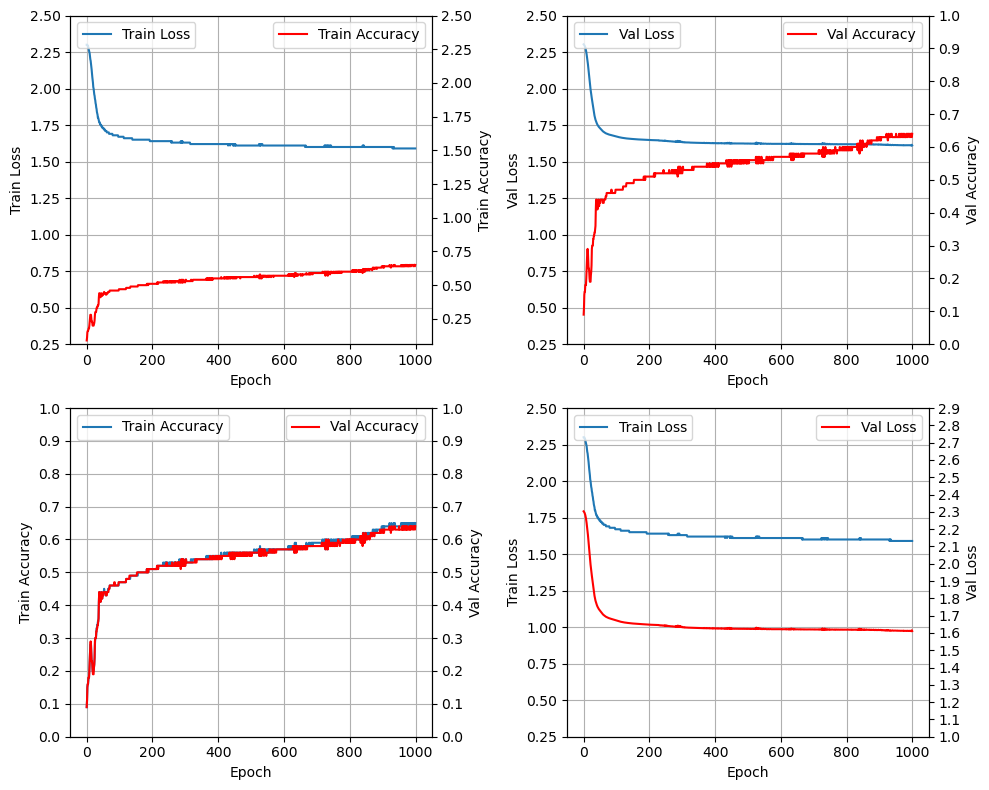

In [19]:
# 손실과 정확도 비교

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(loss_list[0], label="Train Loss")
axes[0, 0].legend(loc="upper left")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Train Loss")
axes[0, 0].set_yticks(np.arange(0.25, 2.51, 0.25))
axes[0, 0].grid()
axes1 = axes[0, 0].twinx()
axes1.plot(accuracy_list[0], label="Train Accuracy", color="red")
axes1.legend(loc="upper right")
axes1.set_ylabel("Train Accuracy")
axes1.set_yticks(np.arange(0.25, 2.51, 0.25))

axes[0, 1].plot(loss_list[1], label="Val Loss")
axes[0, 1].legend(loc="upper left")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Val Loss")
axes[0, 1].set_yticks(np.arange(0.25, 2.51, 0.25))
axes[0, 1].grid()
axes2 = axes[0, 1].twinx()
axes2.plot(accuracy_list[1], label="Val Accuracy", color="red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Val Accuracy")
axes2.set_yticks(np.arange(0, 1.1, 0.1))


axes[1, 0].plot(accuracy_list[0], label="Train Accuracy")
axes[1, 0].legend(loc="upper left")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Train Accuracy")
axes[1, 0].set_yticks(np.arange(0, 1.1, 0.1))
axes[1, 0].grid()
axes3 = axes[1, 0].twinx()
axes3.plot(accuracy_list[1], label="Val Accuracy", color="red")
axes3.legend(loc="upper right")
axes3.set_ylabel("Val Accuracy")
axes3.set_yticks(np.arange(0, 1.1, 0.1))


axes[1, 1].plot(loss_list[0], label="Train Loss")
axes[1, 1].legend(loc="upper left")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Train Loss")
axes[1, 1].set_yticks(np.arange(0.25, 2.51, 0.25))
axes[1, 1].grid()
axes4 = axes[1, 1].twinx()
axes4.plot(loss_list[1], label="Val Loss", color="red")
axes4.legend(loc="upper right")
axes4.set_ylabel("Val Loss")
axes4.set_yticks(np.arange(1, 3, 0.1))
plt.tight_layout()
plt.show()